## Image slicing

In [19]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import math, os, glob
from pathlib import Path 
import pathlib

%matplotlib inline

In [33]:
#Remove cap on max pixels for Image package
Image.MAX_IMAGE_PIXELS = None

In [70]:
file_name="20190621_Mauritania_WV-3_50cm_WGS84_UTM28N_NorthTile.tif"
dir='..\\data' #dir='../data' if macos
f=os.path.join(dir,file_name)

In [35]:
"""
Slices image into patches of size nxn according to stride
Zero pads any patches that are cut off at borders of image
Returns numpy array of image patches
"""

def slice_image(img, n, stride, channels):
    x_dim, y_dim = img.shape[0], img.shape[1]
    
    # calculate number of output slices
    num_x = math.ceil((x_dim-n)/stride + 1)
    num_y = math.ceil((y_dim-n)/stride + 1)

    # iterate through img 
    results = np.zeros((num_x*num_y, n, n, channels), dtype=int)
    counter = 0

    for i in range(num_y):
        y = 0 if i==0 else y + stride
        for j in range(num_x):
            x = 0 if j==0 else x + stride

            im_slice = img[x:x+n, y:y+n]
            
            dims = im_slice.shape
            if channels == 1:
                im_slice = im_slice.reshape((dims[0],dims[1],1))
            results[counter,0:im_slice.shape[0],0:im_slice.shape[1]] = im_slice
            counter += 1
    return results

### Example usage on single image

By setting *n* to 512, we will end up with 512x512 image slices.  

When the `stride` value is equal to `n`, there is no overlap in the output image slices.  If we set `stride` to 256, each slice would overlap its neighboring slices by 50%.  

For RGB images, `channels` should be set to 3, one for each color channel (red, green, blue).  Black and white images have 1 channel, so this value should be adjusted.  

The path to your sample file `f` should be updated.

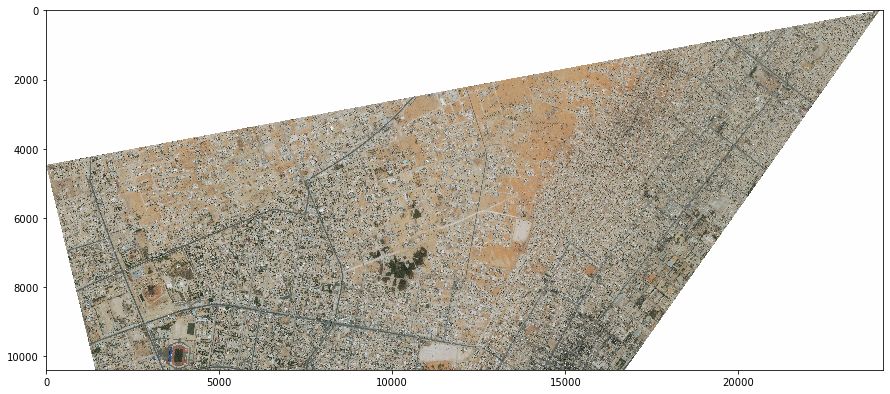

In [71]:
n = 512
stride = n
channels = 3

im = Image.open(f)
im_arr = np.asarray(im)
plt.figure(figsize=(15,15))
plt.imshow(im_arr)

The width and height of the image is ....

In [39]:
im_arr.shape

(10385, 24179, 3)

The shape of our `results` array tells us we have:
4 image slices that are
512x512 pixels with
3 color channels (RGB)

In [40]:
results = slice_image(im_arr, n, stride, channels)
results.shape

(1008, 512, 512, 3)

The below image slice is the top left of the original image:

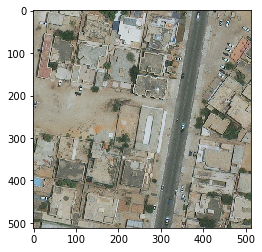

In [58]:
plt.imshow(results[250])

### Slice all images, saving output

All images to be sliced should be in one folder, and we set `im_dir` to the path of that folder.  The image slices will be written to a parallel directory, appended with the `postfix` and pixel size `n`

### Use TFW to calculate the location 
    

### This is the remaining formula for each slice location
x1 = A*x + B*y + C

y1 = D*x + E*y + F

name_width_height_x_y_n.png
 


In [80]:
# use same folder above (in Windows) or else use default data path
im_dir = dir

postfix = '_sliced'

im_dir_out = im_dir + postfix + '_' + str(n)
print(im_dir_out)

..\data_sliced_512


In [84]:
im_filenames = glob.glob(im_dir+'/*', recursive=True)

# Create output directories 
if not os.path.exists(im_dir_out):
    os.makedirs(im_dir_out)

for i, im_filename in enumerate(im_filenames):
    im = Image.open(im_filename)
    im = np.asarray(im)
    filename = im_filename.split('/')[-1] #get image name

    #width of the original image
    img_x_dim=im.shape[0]

    #height of the original image
    img_y_dim=im.shape[1]

    #num image slices in x direction
    num_slices_x=math.ceil(img_x_dim/n)

    #num image slices in y direction
    num_slices_y=math.ceil(img_y_dim/n)

    im_slices = slice_image(im, n, stride, 3)
    
    for j, im_slice in enumerate(im_slices):
        result = Image.fromarray(im_slice.astype(np.uint8))
        x=(j-(math.ceil(j/num_slices_x)-1)*num_slices_x)*n #pixel coordinate in x-direction for slice
        y=math.ceil(j/num_slices_x)*n
        outfile=os.path.join(im_dir_out,filename.split('.')[2].split('\\')[-1]+'_'+str(j)+"_"+str(img_x_dim)+"_"+\
            "_"+str(img_y_dim)+"_"+"_"+str(x)+"_"+"_"+str(y)+"_"+str(n)+".tif")
        # print(outfile)
        result.save(outfile)
        
    print("Processed image {}: {} ".format(i+1, filename))
    print("Dim: {}, Slices: {}".format(im.shape, im_slices.shape[0]))

Processed image 1: ..\data\20190621_Mauritania_WV-3_50cm_WGS84_UTM28N_NorthTile.tif 
Dim: (10385, 24179, 3), Slices: 1008
